In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
import os,random
import keras
#os.environ["KERAS_BACKEND"] = "theano"

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICE"]  = '0'
#os.environ["THEANO_FLAGS"]  = "floatX=float32"
#os.environ["THEANO_FLAGS"]  = "device=cuda%d"%(1)

In [2]:
import numpy as np
import seaborn as sns
import pickle, random, sys

In [3]:
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam
#import theano as th
#import theano.tensor as T
import os
WEIGHTS_PATH = ('resnet_like_weights_tf_dim_ordering_tf_kernels.h5')
from keras.models import Model
from keras.layers import Input,Dense,Conv1D,MaxPool1D,ReLU,Dropout,Softmax
from keras.layers import LSTM
import keras
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
import tensorflow as tf

In [4]:
import importlib,sys

importlib.reload(sys)

<module 'sys' (built-in)>

In [5]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

In [6]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [11]:
# Load the dataset ...
#  You will need to seperately download or generate this file
dbfile = open('RML2016.10a_dict.dat', 'rb')      
Xd = pickle.load(dbfile,encoding='latin1') 

In [12]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [14]:
print('数据集总数：',n_examples)
print('调制方式' , len(mods),'种:' ,mods)
print('信噪比:',snrs)

数据集总数： 220000
调制方式 11 种: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
信噪比: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


# Feature Extraction

## accumulat_features

In [15]:
# accumulation feature
def accumulat_features(x): # accumulation feature and the input is complex
    
    x_r = np.conjugate(x)

    M20 = np.mean(np.power(x, 2), axis = 2, keepdims = True)
    M21 = np.mean(np.power(np.abs(x), 2), axis = 2, keepdims = True)
    M22 = np.mean(np.power(x_r, 2), axis = 2, keepdims = True)
    M40 = np.mean(np.power(x, 4), axis = 2, keepdims = True)
    M41 = np.mean(np.power(np.abs(x), 2)*np.power(x, 2), axis = 2, keepdims = True)
    M42 = np.mean(np.power(np.abs(x), 4), axis = 2, keepdims = True)
    M43 = np.mean(np.power(np.abs(x), 2)*np.power(x_r, 2), axis = 2, keepdims = True)
    M60 = np.mean(np.power(x, 6), axis = 2, keepdims = True)
    M63 = np.mean(np.power(np.abs(x), 6), axis = 2, keepdims = True)
    M80 = np.mean(np.power(x, 8), axis = 2, keepdims = True)

    C20 = M20
    C21 = M21
    C40 = M40 - 3*np.power(M20, 2)
    C41 = M41 - 3*M20*M21
    C42 = M42 - np.power(np.abs(M20), 2) - 2*np.power(M21, 2)
    C60 = M60 - 15*M20*M40 + 30*np.power(M20, 3)
    C63 = M63 - 6*M41*M20 - 9*M42*M21 + 18*M20*M20*M21 + 12*np.power(M21, 3)
    C80 = M80 - 28*M20*M60 - 35*M40*M40 + 420*M20*M20*M40 - 630*np.power(M20, 4)

    T1 = np.abs(C80) / np.power(np.abs(C42), 2)
    T2 = np.abs(C80) / np.power(np.abs(C40), 2) # 利用差分（x(k+1) - x(k)）可区分QPSK/OQPSK
    M1 = np.abs(C40) / np.abs(C42)
    M2 = np.power(np.abs(C63), 2) / np.power(np.abs(C42), 3)

    C20_norm = np.abs(C20/C21)
    C40_norm = np.abs(C40/np.power(C21, 2))
    C41_norm = np.abs(C41/np.power(C21, 2))
    C42_norm = np.abs(C42/np.power(C21, 2))
    C60_norm = np.abs(C60/np.power(C21, 3))
    C63_norm = np.abs(C63/np.power(C21, 3))
    C80_norm = np.abs(C80/np.power(C21, 4))

    return [T1, T2, M1, M2, C20_norm, C40_norm, C41_norm, C42_norm, C60_norm, C63_norm, C80_norm]    

In [1]:
# part one: basic feature 
def element_mean(x):
    return np.mean(x, axis=2, keepdims=True)

def element_abs_mean(x):
    return np.abs(np.mean(x, axis=2, keepdims=True))

def element_std(x):
    return np.std(x,axis=2,keepdims=True)

def element_std_abs(x):
    return np.std(np.abs(x),axis=2,keepdims=True)  

def abs_max_mins_min(x):
    return np.abs(np.max(x, axis=2, keepdims=True) - np.min(x, axis=2, keepdims=True))

def max_mins_min_abs(x):
    return np.max(np.abs(x), axis=2, keepdims=True) - np.min(np.abs(x), axis=2, keepdims=True)

def abs_mean_sqr(x):
    return np.abs(np.mean(np.square(x), axis = 2, keepdims=True))

def mean_sqr_abs(x):
    return np.mean(np.square(np.abs(x)), axis = 2, keepdims=True)

def abs_sqrmean_mis_meansqr(x):
    return np.abs(np.mean(np.square(x),axis=2,keepdims=True)- \ np.square(np.mean(x,axis = 2,keepdims=True)))
    
def sqrmean_mis_meansqr_abs(x):
    return np.mean(np.square(np.abs(x)),axis=2,keepdims=True)- \
            np.square(np.mean(np.abs(x),axis = 2,keepdims=True))

def abs_fourmean_mis_meanfour(x):
    return np.abs(np.mean(np.power(x,4),axis=2,keepdims=True)-\
            np.mean(np.square(x),axis=2,keepdims=True)**2) 

def fourmean_mis_meanfour_abs(x):
    return np.mean(np.power(np.abs(x),4),axis=2,keepdims=True)-\
            np.mean(np.square(np.abs(x)),axis=2,keepdims=True)**2

SyntaxError: unexpected character after line continuation character (<ipython-input-1-db4fd0751a2f>, line 27)

In [17]:

# part two: time sequence feature

def absolute_sum_of_changes(x):
    return np.sum(np.abs(np.diff(x,1)), axis=2, keepdims=True)

def agg_autocorrelation(x, l=1):    ##
    x_var = np.var(x, axis=2, keepdims=True)
    x_diff_sum = np.sum(np.diff(x-np.mean(x, axis=2, keepdims=True),l), axis=2, keepdims=True)
    return x_diff_sum / x_var

def approximate_entropy(x):
    return np.sum(-x*np.log(np.abs(x+0.0000001)), axis=2, keepdims=True)

def autocorrelation(x, k=1):
    n = x.shape[2]
    variance = np.var(x, axis=2, keepdims=True)+0.0000001
    x = x-np.mean(x, axis=2, keepdims=True)
    result = np.sum(x[:,:,k:]*x[:,:,:n-k], axis=2, keepdims=True) / (variance*(n-k))
    return result

def cwt_coefficients(x):
    ricker = (1-x**2/4)*np.exp(-x**2/8)
    result = np.mean(ricker, axis=2, keepdims=True)
    return result

def count_above_mean(x):
    mask = (x - np.mean(x, axis=2, keepdims=True))>0
    result = np.sum(mask, axis=2, keepdims=True)
    return result

def count_below_mean(x):
    mask = (x - np.mean(x, axis=2, keepdims=True))<0
    result = np.sum(mask, axis=2, keepdims=True)
    return result

def first_location_of_maximum(x): ##
    result = np.argmax(x, axis=2)
    return result.reshape(result.shape[0], result.shape[1], 1)

def first_location_of_minimum(x): ##
    result = np.argmin(x, axis=2)
    return result.reshape(result.shape[0], result.shape[1], 1)

def kurtosis(x):
    x = x - np.mean(x, axis=2, keepdims=True)
    e4 = np.mean(pow(x, 4), axis=2, keepdims=True)
    e2 = pow(np.mean(pow(x, 2), axis=2, keepdims=True),2)
    result = e4/e2
    return result

def skewness(x):
    variance = np.var(x, axis=2, keepdims=True)+0.0000001
    x = x - np.mean(x, axis=2, keepdims=True)
    result = np.mean(pow(x/variance, 3), axis=2, keepdims=True)
    return result

In [18]:
# feature function
# part three: modulation feature

def max_amp_density_abs(X_complex_abs):
    
    # The maximum value of the normalized spectral density of the amplitude with Zero Center
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    Acn_complex_max = np.max(np.abs(np.fft.fft(Acn,axis=2))**2, axis = 2, keepdims = True) / X_complex_abs.shape[2]
    return Acn_complex_max
    
def std_phase_abs(X_complex_angl, X_complex_abs):
    # Standard deviation of absolute value of instantaneous phase nonlinear component at zero Center
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    angl_mins_mean = X_complex_angl - np.mean(X_complex_angl,axis=2,keepdims=True)
    angl_mins_mean_after_mask = angl_mins_mean * sqr_mask
    result = np.sqrt(np.sum(np.square(angl_mins_mean_after_mask),axis=2,keepdims=True)/sqr_mask_sum -
                                     (np.sum(np.abs(angl_mins_mean_after_mask),axis=2,keepdims=True)/sqr_mask_sum)**2)
    return result

def std_phase(X_complex_angl, X_complex_abs):
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    angl_mins_mean = X_complex_angl - np.mean(X_complex_angl,axis=2,keepdims=True)
    angl_mins_mean_after_mask = angl_mins_mean * sqr_mask
    result = np.sqrt(np.sum(np.square(angl_mins_mean_after_mask),axis=2,keepdims=True)/sqr_mask_sum - 
                                     (np.sum(angl_mins_mean_after_mask,axis=2,keepdims=True)/sqr_mask_sum)**2) 
    return result

def std_amp_abs(X_complex_abs):
    
    # Standard deviation of instantaneous amplitude absolute value of Zero Center normalized non weak signal
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    result = np.sqrt(np.mean(np.square(Acn),axis=2,keepdims=True) - 
                                     np.mean(np.abs(Acn),axis=2,keepdims=True)**2) 
    return result

def std_fre_abs(X_complex_fre, X_complex_abs):
    # Standard deviation of instantaneous frequency absolute value of Zero Center normalized non weak signal
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    fn = X_complex_fre - np.mean(X_complex_fre,axis=2,keepdims=True)
    fn_after_mask = fn * sqr_mask
    result = np.sqrt(np.sum(np.square(fn_after_mask),axis=2,keepdims=True)/sqr_mask_sum - 
                                     (np.sum(np.abs(fn_after_mask),axis=2,keepdims=True)/sqr_mask_sum)**2) 
    return result

def std_amp(X_complex_abs):
    # Standard deviation of instantaneous amplitude of Zero Center normalized non weak signal
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    Acn_after_mask = Acn * sqr_mask
    result = np.sqrt(np.sum(np.square(Acn_after_mask),axis=2,keepdims=True)/sqr_mask_sum - 
                                     (np.sum(Acn_after_mask,axis=2,keepdims=True)/sqr_mask_sum)**2) 
    return result    

def den_amp(X_complex_abs):
    # Compactness of Zero Center normalized instantaneous amplitude
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    result = np.mean(np.power(Acn, 4),axis=2,keepdims=True) / np.mean(np.square(Acn),axis=2,keepdims=True)**2 
    return result 

def den_fre(X_complex_fre):
    # Compactness of Zero Center normalized instantaneous frequency
    fn = X_complex_fre - np.mean(X_complex_fre,axis=2,keepdims=True)
    result = np.mean(np.power(fn, 4),axis=2,keepdims=True) / np.mean(np.square(fn),axis=2,keepdims=True)**2 
    return result 

In [19]:
# feature filter with the index got from random forest

index_layer_list = ['c 0 0 3', 't 5 0 20', 't 5 1 20', 'c 0 0 4', 't 3 0 8', 't 3 1 2', 't 6 1 20', 'c 0 3 0', 't 3 0 20', 't 3 3 3', 't 5 1 13', 'c 0 2 3', 't 5 3 8', 'c 1 0 1', 't 4 1 2', 'c 1 1 5', 'c 1 2 5', 't 6 1 19', 't 3 2 9', 't 3 0 2', 'c 0 1 3', 'c 0 1 2', 't 3 1 9', 't 5 3 25', 't 3 3 25', 'c 1 3 5', 't 6 2 19', 't 6 0 20', 'c 0 1 0', 't 4 1 11', 'c 0 0 2', 't 4 0 20', 't 3 2 20', 't 2 0 23', 't 4 1 3', 't 3 4 20', 't 4 4 13', 't 2 1 6', 't 3 4 0', 't 7 1 18', 't 5 4 17', 't 3 1 20', 'c 0 2 2', 't 3 3 9', 't 0 4 23', 't 2 3 23', 't 7 1 26', 't 3 2 2', 't 5 1 6', 't 7 1 27', 't 6 2 2', 't 3 3 20', 't 4 4 7', 't 6 3 23', 't 5 0 9', 't 2 0 25', 't 3 4 8', 't 3 4 2', 't 6 3 10', 't 0 0 24', 't 6 2 3', 't 4 2 2', 't 4 0 22', 't 3 2 8', 'c 1 2 4', 't 0 4 21', 't 7 0 25', 't 0 4 24', 't 3 4 9', 't 5 4 22', 't 5 4 9', 't 5 3 3', 't 8 0 24', 't 6 3 21', 't 4 1 15', 't 5 3 5', 't 3 4 24', 't 5 2 21', 't 3 3 5', 't 5 3 11', 't 6 4 23', 't 6 3 9', 't 5 4 25', 't 4 3 4', 't 3 0 18', 't 3 4 23', 't 6 4 16', 't 4 1 9', 't 6 3 3', 't 6 2 10', 't 3 0 16', 't 3 0 26', 't 3 0 3', 't 5 1 15', 't 4 0 2', 't 6 1 16', 't 6 1 15', 't 5 3 24', 't 4 1 8', 't 4 0 15', 't 5 3 21', 't 6 2 14', 't 5 0 15', 't 5 2 14', 'c 1 0 4', 't 3 0 15', 'c 0 3 3', 't 0 1 14', 'c 0 2 0', 't 5 0 16', 't 4 1 6', 't 3 1 8', 't 3 3 10', 't 3 3 4', 'c 0 3 2', 't 2 1 17', 't 3 1 19', 't 6 3 26', 't 3 1 7', 't 5 3 27', 't 3 1 16', 't 3 2 3', 't 6 3 27', 't 1 2 14', 'c 1 4 5', 't 5 3 4', 't 6 1 1', 't 4 1 16', 't 6 0 15', 't 5 0 14', 't 7 1 21', 't 2 3 14', 't 4 2 9', 't 3 3 8', 't 6 3 11', 't 5 1 1', 't 4 1 14', 't 3 0 27', 't 6 2 0', 't 3 4 14', 'c 0 2 5', 't 3 0 9', 't 6 3 5', 't 4 4 23', 't 4 0 8', 't 2 2 24', 't 3 4 21', 't 4 0 9', 't 3 3 14', 't 5 1 9', 't 5 3 10', 't 6 3 25', 't 2 1 3', 't 3 4 27', 't 4 0 18', 't 2 2 9', 't 5 4 14', 't 6 0 16', 't 3 3 2', 't 6 4 14', 't 5 4 23', 't 4 2 14', 't 3 1 3', 't 5 1 16', 't 4 0 3', 't 4 1 23', 'c 0 4 2', 't 5 3 14', 't 3 0 14', 't 8 4 26', 't 2 2 22', 't 0 2 15', 't 6 4 15', 't 2 2 8', 't 4 3 14', 't 7 1 8', 't 6 0 14', 't 4 1 19', 't 4 0 14', 't 3 1 14', 't 2 3 11', 't 4 3 5', 't 8 1 10', 't 2 2 16', 't 0 3 14', 't 5 4 18', 't 1 0 12', 't 7 1 9', 't 3 4 1', 't 3 3 18', 't 2 2 14', 't 6 4 20', 't 6 3 4', 't 7 1 10', 't 2 3 7', 't 3 4 25', 't 3 2 10', 't 4 0 16', 'c 0 1 4', 't 4 0 21', 't 7 1 23', 't 2 2 10', 't 5 4 15', 't 3 3 11', 't 2 0 8', 't 6 3 14', 't 6 1 14', 't 5 4 21', 't 2 0 3', 't 2 1 0', 't 1 1 6', 't 7 3 14', 't 4 0 26', 't 8 0 26', 't 6 4 18', 't 3 1 23', 't 2 1 11', 't 4 2 11', 't 3 4 26', 't 3 0 10', 't 3 0 0', 't 6 1 2', 't 7 1 22', 't 8 1 26', 't 5 4 12', 't 2 2 1', 't 7 1 24', 't 7 4 12', 't 2 1 9', 't 4 2 27', 't 5 2 8', 't 3 1 15', 't 2 1 2', 't 2 2 3', 't 0 3 4', 't 5 3 26', 't 4 2 24', 't 2 1 14', 'c 0 0 5', 'c 1 0 5', 't 5 1 14', 't 5 4 27', 't 4 1 7', 't 5 0 12', 't 3 2 27', 't 6 4 21', 't 6 1 7', 't 6 3 18', 't 2 0 1', 't 6 0 23', 't 4 2 7', 't 5 0 3', 't 0 4 16', 't 2 0 6', 't 2 0 11', 't 2 3 9', 't 4 1 21', 't 2 1 16', 't 5 3 20', 't 5 1 19', 't 8 3 27', 't 0 0 17', 't 2 2 7', 't 4 4 16', 't 2 2 2', 't 5 1 7', 't 7 1 14', 't 3 3 0', 't 1 2 8', 't 3 4 10', 't 0 2 8', 't 0 1 13', 't 4 2 19', 't 1 1 13', 't 1 1 15', 't 4 4 12', 't 3 0 25', 't 0 4 25', 't 4 0 27', 't 7 0 12', 't 2 4 23', 't 6 1 22', 't 8 2 18', 't 5 2 19', 't 3 0 24', 't 7 1 1', 't 5 0 18', 't 5 1 17', 't 6 1 13', 't 2 1 24', 't 6 3 19', 'c 0 3 1', 't 3 1 22', 't 3 3 27', 't 4 4 14', 't 1 4 14', 't 0 4 12', 't 2 1 1', 't 3 2 16', 't 5 1 21', 't 1 0 18', 't 4 0 24', 't 8 2 27', 'c 0 4 5', 't 4 0 12', 't 8 4 27', 't 2 0 10', 't 2 3 17', 't 2 0 9', 'c 0 1 5', 't 4 1 10', 't 5 2 25', 't 4 3 11', 't 5 3 17', 't 6 1 8', 't 4 2 12', 'c 1 0 2', 't 4 2 8', 't 7 2 21', 't 5 3 23', 't 6 4 11', 't 4 3 27', 't 3 2 14', 't 5 2 13', 't 4 0 23', 't 2 1 13', 't 3 4 3', 't 5 4 20', 't 1 1 14', 't 5 0 2', 't 2 1 23', 'c 1 4 4', 't 2 4 14', 't 3 3 12', 't 2 2 5', 't 4 0 0', 't 3 1 24', 't 1 1 23', 't 0 4 14', 't 7 1 2', 't 2 2 13', 't 3 3 26', 't 6 4 12', 't 4 1 17', 't 5 3 18', 't 6 2 20', 't 5 1 23', 't 1 2 13', 't 0 4 5', 't 0 0 8', 't 6 1 3', 't 3 3 23', 't 6 4 5', 't 4 1 24', 't 1 3 10', 't 4 0 19', 't 7 2 16', 't 1 3 23', 't 1 4 12', 't 1 2 12', 't 4 0 10', 't 0 1 27', 't 1 4 13', 't 8 0 27', 't 3 2 22', 't 0 1 22', 't 1 2 24', 't 2 2 21', 't 8 2 21', 't 5 4 16', 't 5 2 26', 't 4 4 25', 't 7 1 17', 't 3 0 17', 't 0 2 17', 't 4 2 22', 'c 1 0 3', 't 6 4 9', 't 8 1 18', 't 4 3 19', 't 8 1 8', 'c 1 1 3', 'c 1 3 4', 't 5 2 9', 't 1 3 4', 't 6 0 10', 't 4 3 25', 't 1 2 0', 't 6 2 16', 't 0 1 15', 't 1 3 27', 't 8 4 18', 't 4 3 26', 't 1 0 24', 't 5 0 1', 't 6 0 12', 'c 1 2 1', 't 2 3 2', 't 2 0 12', 't 6 0 5', 't 5 1 3', 't 0 1 16', 't 2 2 11', 't 2 4 24', 't 6 2 15', 't 2 0 0', 't 1 0 22', 't 8 0 12', 't 6 0 0', 't 6 2 9', 't 2 4 9', 't 6 4 10', 't 8 0 7', 't 3 4 15', 't 8 0 17', 't 6 0 19', 't 6 2 26', 't 2 1 8', 't 4 4 27', 't 4 1 22', 't 7 2 24', 't 1 4 16', 'c 0 2 4', 't 0 2 14', 't 6 4 24', 't 7 3 25', 't 6 0 1', 't 1 4 0', 't 4 4 8', 't 2 0 14', 't 1 0 2', 't 4 2 16', 't 1 4 1', 't 1 2 17', 'c 1 4 1', 't 4 4 4', 't 5 1 10', 't 6 3 1', 't 5 3 13', 't 8 0 6', 't 3 4 18', 't 6 4 8', 't 0 3 25', 't 1 0 10', 't 2 4 12', 't 0 0 27', 't 4 2 6', 't 0 2 11', 't 3 2 25', 't 5 2 22', 't 1 3 18', 't 4 2 1', 't 1 4 26', 't 6 3 2', 't 6 0 3', 't 8 2 2', 't 6 0 21', 't 0 2 26', 't 1 2 16', 't 4 1 12', 't 4 4 6', 't 5 3 7', 't 6 1 27', 't 6 2 13', 't 1 0 7', 't 6 0 9', 't 0 1 0', 't 3 1 21', 't 0 3 5', 't 0 0 12', 't 0 3 27', 't 2 1 7', 't 8 4 19', 't 7 1 12', 'c 0 4 4', 't 4 3 24', 't 0 3 18', 't 3 1 18', 't 6 2 6', 't 2 2 25', 't 2 1 19', 't 3 0 23', 't 3 1 25', 't 5 0 21', 'c 0 3 4', 't 2 3 22', 't 5 3 15', 't 2 1 12', 't 5 2 3', 't 3 2 15', 't 6 4 22', 't 3 2 11', 't 8 2 12', 't 6 3 22', 't 8 4 21', 't 6 1 11', 't 0 1 8', 't 4 4 5', 't 2 1 25', 't 0 0 26', 'c 0 4 0', 't 6 0 8', 't 3 4 12', 't 2 4 6', 't 2 0 17', 't 2 2 6', 't 6 4 4', 't 4 1 18', 't 3 2 4', 't 7 2 11', 't 0 2 5', 'c 1 1 4', 't 6 1 23', 't 0 0 5', 't 4 0 1', 't 2 0 24', 't 7 4 5', 't 5 4 4', 't 7 4 16', 'c 1 0 0', 't 4 2 5', 't 5 3 1', 't 4 4 26', 't 0 1 5', 't 0 0 14', 't 8 3 21', 't 1 3 16', 't 4 3 22', 't 8 0 8', 't 1 1 10', 't 0 2 24', 't 4 3 0', 't 2 3 5', 't 5 3 9', 't 6 4 26', 't 1 0 21', 't 6 4 25', 't 1 2 15', 't 5 4 26', 't 4 2 21', 't 3 1 5', 't 3 1 10', 't 6 2 24', 't 7 1 16', 't 8 1 21', 't 0 0 18', 't 8 4 9', 't 1 0 14', 't 7 0 14', 't 6 3 12', 't 8 4 3', 't 3 0 7', 't 2 3 3', 't 1 4 15', 't 5 4 10', 't 6 2 22', 't 6 4 27', 't 8 4 14', 't 7 4 0', 't 3 2 19', 't 5 2 23', 't 8 4 2', 't 0 1 25', 't 5 4 0', 't 0 4 4', 't 7 0 2', 't 3 1 11', 'c 1 3 1', 't 1 2 1', 't 7 4 25', 't 8 4 24', 't 7 0 15', 't 4 4 15', 't 5 4 11', 't 1 1 0', 't 3 2 12', 't 8 3 18', 't 8 1 23', 't 3 0 11', 't 0 4 9', 't 1 4 2', 't 5 0 25', 't 7 1 25', 't 7 4 14', 'c 1 4 2', 't 4 3 10', 't 4 3 3', 't 1 4 4', 't 0 4 0', 't 2 4 22', 't 4 3 20', 't 3 2 24', 't 4 1 25', 't 5 1 0', 'c 1 1 2', 't 8 1 5', 't 3 4 5', 't 1 3 0', 't 6 3 8', 't 5 1 8', 't 8 3 24', 't 5 4 5', 't 5 3 12', 't 2 4 8', 't 8 1 4', 't 7 2 23', 't 7 3 1', 'c 0 3 5', 't 3 2 17', 't 0 2 0', 't 8 0 0', 't 0 4 2', 't 3 4 19', 't 6 1 6', 't 3 3 21', 't 8 4 11', 't 2 0 19', 't 8 2 14', 't 4 3 23', 't 5 2 16', 't 5 2 15', 't 0 0 22', 't 8 2 23', 't 2 3 8', 't 7 3 15', 't 0 3 10', 't 7 2 19', 't 7 3 5', 't 2 4 21', 't 2 0 18', 't 3 2 18', 't 1 2 26', 't 8 2 19', 't 0 4 27', 't 5 2 2', 't 6 3 20', 't 4 1 0', 't 4 2 3', 't 1 2 22', 't 0 3 22', 't 0 0 1', 'c 0 0 0', 't 0 4 26', 't 0 3 2', 't 5 4 24', 't 5 2 11', 't 7 3 23', 't 6 2 18', 't 8 2 7', 't 7 3 24', 't 0 2 18', 'c 1 2 0', 't 1 2 2', 't 5 3 2', 't 4 1 13', 't 0 0 10', 't 5 4 1', 't 2 2 17', 't 0 2 13', 't 7 4 11', 't 8 4 17', 't 6 0 27', 't 6 1 12', 't 7 4 13', 't 8 2 10', 't 0 2 25', 't 2 3 27', 't 4 2 25', 't 3 3 24', 't 4 0 25', 't 3 1 27', 't 0 0 4', 't 3 4 17', 't 4 0 5', 't 1 4 3', 't 1 4 25', 't 3 1 12', 't 5 2 17', 't 2 3 12', 't 8 3 0', 't 0 3 0', 't 2 4 18', 't 7 1 5', 't 7 0 4', 't 7 1 19', 't 8 0 11', 't 3 3 16', 't 0 0 25', 't 2 2 27', 't 8 1 22', 't 0 1 23', 't 2 0 22', 't 4 0 11', 't 7 1 7', 't 4 2 20', 't 0 0 21', 't 1 2 4', 't 7 0 19', 't 8 0 5', 't 1 1 1', 't 5 0 4', 't 8 4 10', 't 1 0 19', 't 8 4 22', 't 1 4 18', 't 0 4 13', 't 6 4 7', 't 0 2 2', 't 6 2 11', 't 7 2 2', 't 7 2 5', 't 2 4 11', 't 2 3 16', 't 1 1 2', 't 1 0 15', 't 1 1 25', 't 5 1 5', 't 1 3 22', 't 0 3 13', 't 7 3 17', 't 2 1 27', 'c 1 1 1', 't 7 3 21', 'c 1 2 3', 'c 1 4 0', 't 7 0 1', 't 0 2 9', 't 1 3 13', 't 8 3 19', 't 7 2 27', 't 8 0 25', 't 7 1 13', 't 1 1 5', 't 6 1 21', 't 1 2 23', 't 0 0 0', 't 4 1 27', 't 3 2 23', 't 2 2 19', 't 1 2 27', 't 6 4 17', 't 4 2 23', 't 5 0 27', 't 5 2 10', 't 5 2 12', 't 8 0 21', 't 3 1 13', 't 1 1 11', 't 0 0 11', 't 7 3 9', 't 3 3 15', 't 8 3 6', 't 0 3 3', 't 7 1 3', 't 7 3 7', 't 2 0 21', 't 7 2 12', 't 2 4 3', 't 7 0 26', 't 0 1 18', 't 7 2 6', 't 4 3 18', 't 1 3 25', 't 3 0 1', 't 3 2 0', 't 6 0 2', 'c 1 3 0', 't 5 1 2', 't 2 3 6', 't 8 2 11', 't 0 3 1', 't 0 2 1', 't 8 0 13', 't 0 3 6', 't 7 3 22', 't 2 3 13', 't 2 3 24', 't 6 0 4', 't 5 2 4', 't 1 2 7', 't 8 1 9', 't 8 3 3', 't 5 2 5', 't 8 2 15', 't 6 1 25', 't 6 2 4', 't 4 2 15', 't 7 3 12', 't 2 4 1', 't 7 4 9', 't 2 2 0', 't 1 3 5', 't 4 3 1', 't 8 1 19', 't 8 3 26', 't 4 1 26', 't 0 3 16', 't 8 3 1', 't 7 0 27', 't 6 3 6', 't 2 0 7', 't 8 3 7', 't 6 2 21', 't 7 2 25', 't 8 0 19', 't 0 1 1', 't 1 4 6', 't 1 0 5', 't 8 2 3', 'c 0 4 1', 't 8 4 4', 't 0 4 22', 't 3 3 1', 't 3 0 5', 't 2 0 15', 't 2 1 18', 't 7 4 1', 't 1 1 17', 't 7 2 22', 't 6 0 17', 't 5 1 25', 't 8 0 4', 't 7 2 26', 't 6 3 15', 't 3 1 1', 't 3 3 6', 't 7 4 4', 't 3 0 13', 't 7 0 13', 't 2 4 5', 't 4 4 17', 't 0 1 4', 't 2 4 2', 't 2 3 21', 't 5 1 11', 't 6 0 13', 't 1 1 21', 't 3 0 22', 't 7 2 4', 't 3 3 22', 't 8 3 12', 't 5 4 13', 't 6 4 0', 'c 1 1 0', 't 3 0 6', 't 1 0 3', 't 8 1 25', 't 1 1 24', 't 1 1 7', 't 7 2 17', 't 5 2 20', 't 4 3 9', 't 5 3 6', 't 7 2 8', 't 2 4 16', 't 6 1 9', 't 0 0 23', 't 7 1 11', 't 6 3 17', 't 7 3 10', 't 2 1 21', 't 4 0 7', 't 4 3 13', 't 1 1 16', 't 3 0 4', 't 8 0 3', 't 6 2 8', 't 5 1 22', 't 8 1 2', 't 5 4 8', 't 0 0 2', 't 7 2 7', 't 8 2 4', 't 5 0 5', 't 2 2 18', 't 8 4 16', 't 8 0 15', 't 7 2 13', 't 3 2 26', 't 2 4 0', 't 2 0 2', 't 0 2 21', 't 8 4 5', 't 0 1 11', 't 5 1 27', 't 3 1 6', 'c 0 2 1', 't 7 0 16', 't 8 2 8', 't 1 0 4', 't 0 3 23', 't 2 4 26', 't 1 2 9', 't 4 3 8', 't 5 1 4', 't 8 2 0', 't 1 0 11', 't 0 2 22', 't 1 1 4', 't 7 3 13', 't 2 0 16', 't 4 4 20', 't 5 0 0', 't 7 0 5', 't 7 2 1', 't 7 4 27', 't 1 0 1', 't 8 0 9', 't 0 2 16', 't 7 0 9', 't 0 1 21', 't 4 2 10', 't 8 2 26', 't 4 4 11', 't 6 1 10', 't 8 1 15', 't 2 4 27', 't 8 4 0', 't 2 1 22', 't 3 0 19', 't 1 3 2', 't 8 2 24', 't 2 3 4', 't 6 2 12', 't 1 2 5', 't 7 4 3', 't 6 0 18', 't 0 3 7', 't 2 0 4', 't 2 1 26', 't 5 2 18', 't 8 3 9', 't 8 4 7', 't 4 3 15', 't 7 2 14', 't 5 0 19', 't 7 1 0', 't 8 0 1', 't 2 0 26', 't 8 0 22', 't 3 1 0', 't 1 2 3', 't 6 4 13', 't 3 0 12', 't 4 4 21', 't 0 0 6', 't 7 4 2', 't 4 1 1', 't 4 2 17', 't 6 3 24', 't 3 3 17', 't 1 1 26', 't 0 3 17', 't 5 3 16', 't 0 1 12', 't 3 2 1', 't 2 1 15', 't 5 4 7', 't 2 1 5', 't 7 3 8', 't 2 3 25', 't 6 4 6', 't 1 3 11', 't 0 4 18', 't 5 0 23', 't 4 1 5', 't 2 4 25', 't 1 4 27', 't 4 0 17', 't 1 1 12', 't 2 2 15', 't 8 1 6', 't 5 3 0', 't 1 1 22', 't 1 4 7', 't 0 2 27', 't 0 0 13', 't 0 3 26', 't 5 4 6', 't 7 1 15', 't 7 3 19', 't 1 3 12', 't 7 4 10', 't 2 4 7', 't 2 0 13', 't 0 1 7', 't 8 1 24', 'c 0 4 3', 't 8 3 5', 't 2 4 15', 't 8 3 25', 't 8 3 13', 't 5 3 22', 't 1 1 8', 't 1 0 25', 't 4 1 20', 't 7 3 6', 't 0 1 10', 't 0 1 26', 't 6 4 2', 't 0 2 7', 't 5 2 27', 't 5 1 26', 't 1 3 9', 't 7 0 24', 't 7 0 7', 't 2 3 15', 't 1 3 7', 't 7 3 27', 't 3 3 7', 't 3 4 7', 't 7 3 2', 't 8 3 15', 't 8 4 8', 't 8 1 27', 't 5 0 13', 't 1 0 26', 't 8 4 6', 't 7 2 0', 't 8 2 25', 't 7 4 8', 't 4 2 26', 't 7 3 3', 't 0 0 19', 't 5 1 24', 't 4 4 2', 't 8 4 12', 't 6 1 24', 't 6 1 17', 't 8 3 14', 't 8 2 22', 't 0 2 4', 't 6 4 3', 't 8 3 8', 't 4 4 18', 't 2 2 26', 't 0 2 12', 't 3 1 26', 'c 1 3 3', 't 7 0 8', 't 8 1 14', 't 8 2 17', 't 6 0 11', 't 1 3 14', 't 5 0 11', 't 4 3 2', 't 5 0 26', 't 7 4 21', 't 0 2 10', 't 2 2 23', 't 8 3 2', 't 8 2 1', 't 5 4 3', 't 0 3 24', 't 5 2 24', 't 5 2 1', 't 5 0 8', 't 4 2 13', 't 6 2 23', 't 8 0 18', 't 2 3 20', 't 3 4 4', 't 2 2 4', 't 5 0 24', 't 7 0 3', 't 4 3 12', 't 1 4 10', 't 8 1 7', 't 2 1 4', 't 4 4 22', 't 0 4 1', 't 1 1 9', 't 2 2 12', 't 3 4 13', 't 7 4 26', 't 6 3 13', 't 7 1 4', 't 1 4 24', 't 0 3 9', 't 0 1 6', 't 6 2 17', 't 3 1 4', 't 7 3 11', 't 8 2 16', 't 8 4 13', 't 8 4 23', 't 6 4 19', 't 4 4 10', 't 2 1 10', 't 8 4 15', 't 7 0 18', 't 6 0 26', 't 6 2 7', 't 8 2 9', 't 1 0 16', 't 4 4 0', 't 7 2 18', 't 8 3 4', 't 4 0 4', 't 7 4 20', 't 7 4 24', 't 8 3 10', 't 8 2 13', 't 2 4 19', 'c 0 1 1', 't 3 2 13', 't 3 4 16', 't 1 2 25', 't 8 4 1', 't 1 4 8', 't 7 1 20', 't 4 3 17', 't 1 0 27', 't 8 0 10', 't 7 3 0', 't 7 1 6', 't 8 1 3', 't 8 3 22', 't 6 3 16', 't 0 2 3', 't 6 0 7', 't 0 1 9', 't 1 3 26', 't 4 4 19', 't 7 0 6', 't 4 3 6', 't 1 3 15', 't 2 4 10', 't 8 2 20', 't 0 2 6', 't 5 1 18', 't 1 3 6', 't 1 1 27', 't 4 4 1', 't 7 0 22', 't 0 3 21', 't 8 1 17', 't 5 4 2', 't 0 1 3', 't 8 0 2', 't 5 1 12', 't 6 0 25', 't 4 4 3', 't 1 3 21', 't 1 2 6', 't 7 2 3', 't 7 3 26', 't 5 0 22', 't 3 2 7', 't 0 3 11', 't 7 3 16', 't 1 0 23', 'c 1 3 2', 't 4 4 9', 't 4 4 24', 't 6 1 4', 't 7 4 22', 't 5 2 6', 't 6 0 22', 't 0 4 3', 't 0 0 9', 't 1 3 8', 't 4 1 4', 't 7 4 23', 't 4 0 13', 't 8 0 23', 't 8 3 20', 't 3 0 21', 't 0 1 17', 't 0 3 12', 't 3 3 13', 't 2 4 13', 't 0 1 2', 't 1 3 17', 't 0 4 10', 't 8 1 1', 't 1 4 5', 't 3 4 6', 't 6 4 1', 't 2 0 5', 't 7 0 10', 't 2 4 17', 't 8 2 5', 't 7 4 18', 't 2 3 26', 't 7 4 15', 't 0 4 19', 't 7 3 20', 't 2 3 10', 't 6 0 24', 't 0 0 16', 't 0 0 7', 't 6 2 27', 't 5 0 17', 't 3 3 19', 't 0 4 8', 't 7 4 19', 't 2 0 27', 't 1 3 24', 't 2 4 4', 't 8 3 16', 't 7 3 18', 't 0 4 7', 't 7 4 7', 't 1 4 23', 't 1 0 0', 't 6 1 26', 't 1 2 10', 't 7 0 17', 't 7 2 9', 't 8 3 11', 't 6 1 18', 'c 0 0 1', 't 2 4 20', 't 5 3 19', 'c 1 4 3', 't 2 3 19', 't 2 0 20', 't 1 0 9', 't 1 0 6', 't 1 2 11', 't 7 4 6', 't 1 1 18', 't 1 2 21', 't 6 1 5', 't 5 2 7', 't 8 0 16', 't 1 1 3', 't 7 4 17', 't 6 2 1', 't 1 2 18', 't 5 0 6', 't 8 1 11', 't 1 4 22', 't 5 4 19', 't 0 0 15', 't 2 3 0', 't 1 3 1', 't 8 1 0', 't 1 0 13', 't 4 3 7', 't 6 3 0', 't 5 2 0', 't 3 4 22', 't 6 3 7', 't 6 0 6', 't 2 3 18', 't 8 2 6', 't 4 2 18', 't 4 3 16', 't 8 4 20', 't 7 0 20', 't 0 3 15', 't 7 2 10', 't 0 1 20', 't 8 4 25', 't 7 0 11', 't 3 2 5', 't 0 1 24', 't 7 0 21', 't 8 1 16', 't 7 0 23', 't 7 2 15', 't 0 0 3', 't 5 0 10', 't 8 1 13', 't 1 0 17', 't 8 3 17', 't 1 4 9', 't 1 3 20', 't 7 0 0', 't 0 2 23', 't 7 3 4', 't 4 0 6', 't 0 4 17', 't 3 2 21', 't 6 2 25', 't 3 2 6', 't 4 3 21', 't 8 0 14', 't 0 4 15', 't 4 2 4', 't 8 1 12', 't 2 3 1', 't 1 4 11', 't 1 4 21', 't 6 2 5', 't 1 3 3', 't 1 0 20', 't 3 1 17', 't 0 0 20', 'c 1 2 2', 't 0 4 6', 't 1 1 19', 't 0 3 8', 't 7 2 20', 't 8 1 20', 't 0 4 11', 't 4 2 0', 't 2 2 20', 't 6 1 0', 't 8 3 23', 't 2 1 20', 't 0 3 20', 't 0 3 19', 't 1 4 20', 't 8 0 20', 't 1 4 17', 't 0 4 20', 't 1 0 8', 't 1 2 20', 't 5 0 7', 't 1 2 19', 't 0 1 19', 't 0 2 20', 't 0 2 19', 't 3 4 11', 't 1 1 20', 't 1 4 19', 't 1 3 19']
index_set = set(index_layer_list[:440])
print(len(index_set))

440


In [30]:
# get the time features with the filter index
from tqdm import tqdm
def form_features_time(X):
    
    #Form array of complex numbers; convert each (2,128) sample to a (128,) sample
    
    n_samples = X.shape[0]
    rows = X.shape[1]
    vec_len = X.shape[2]
    input_group = []
    for ran in [0]:
        
        X_I_0 = X[:,0+ran,:]
        X_Q_0 = X[:,1+ran,:]
        X_I_list = [X_I_0]
        X_Q_list = [X_Q_0]
        for i in [2,4,6,8]:
            X_I_tmp = np.concatenate((X_I_0[:, i:], X_I_0[:, :i]), axis = 1)
            X_I_list.append(X_I_tmp * X_I_0)
            X_Q_tmp = np.concatenate((X_Q_0[:, i:], X_Q_0[:, :i]), axis = 1)
            X_Q_list.append(X_Q_tmp * X_Q_0)

        X_complex_0 = X_I_0 + 1j*X_Q_0 # 100*1024
        X_complex_list = [X_complex_0]   
        for i in [2,4,6,8]:
            X_complex_tmp = np.concatenate((X_complex_0[:, i:], X_complex_0[:, :i]), axis = 1)
            X_complex_list.append(X_complex_tmp*X_complex_0)
            
        
        X_I = np.array(X_I_list).swapaxes(0, 1)
        X_Q = np.array(X_Q_list).swapaxes(0, 1)
        X_complex = np.array(X_complex_list).swapaxes(0, 1)   
        del X_I_0, X_Q_0, X_complex_0, X_I_list, X_Q_list, X_complex_list
        
        X_IQ_mul = X_I * X_Q
        X_complex_abs = np.abs(X_complex) # 100 6 1024
        X_complex_abs2 = np.abs(X_I) + np.abs(X_Q) # 100 4 1024
        X_complex_sqr = np.square(np.abs(X_complex))  # 100 4 1024
        X_complex_sqr2 = np.abs(np.square(X_complex))  # 100 4 1024        
        X_complex_angl = np.angle(X_complex) # 100 4 1024
        X_complex_angl_abs = np.abs(X_complex_angl) # 100 4 1024
        X_complex_angl_cir = np.concatenate((X_complex_angl[:, :, 1:], X_complex_angl[:, :, X_complex_angl.shape[2]-1:]), axis = 2)
        X_complex_fre = (X_complex_angl_cir - X_complex_angl) / 6.28 # 100 4 1024
        X_complex_fre_abs = np.abs(X_complex_fre)
        print("X_I", X_I.shape)
        print("X_Q", X_Q.shape)
        print("X_complex", X_complex.shape)
        input_group.extend([X_I, X_Q, X_IQ_mul, X_complex_abs, X_complex_abs2, X_complex_sqr, X_complex_sqr2, X_complex_angl, X_complex_fre])
        
        del X_I, X_Q, X_complex, X_complex_sqr, X_complex_abs, X_complex_angl, X_complex_angl_abs, X_complex_angl_cir, X_complex_fre, X_complex_fre_abs
        g_num = len(input_group)

        
    dict_features = {}
    for i in tqdm(range(len(input_group))):
        for j in range(input_group[0].shape[1]):
            # 9 * 5 * 28 = 1260
            index_list = []
            for z in range(28):
                index = 't' + ' ' + str(i) + ' ' + str(j) + ' ' + str(z)
                if index in index_set:
                    index_list.append(z)
#                 index_list.append(z)
            for k in index_list:
#                 #part one feat_trad
#                 if k==0:
#                     dict_features['element_mean'+str(i)+str(j)] = element_mean(input_group[i][:, j:j+1, :])
#                 elif k==1:
#                     dict_features['element_abs_mean'+str(i)+str(j)] = element_abs_mean(input_group[i][:, j:j+1, :])
#                 elif k==2:
#                     dict_features['element_std'+str(i)+str(j)] = element_std(input_group[i][:, j:j+1, :])
#                 elif k==3:
#                     dict_features['element_std_abs'+str(i)+str(j)] = element_std_abs(input_group[i][:, j:j+1, :])
#                 elif k==4:
#                     dict_features['abs_max_mins_min'+str(i)+str(j)] = abs_max_mins_min(input_group[i][:, j:j+1, :])
#                 elif k==5:
#                     dict_features['max_mins_min_abs'+str(i)+str(j)] = max_mins_min_abs(input_group[i][:, j:j+1, :])
#                 elif k==6:
#                     dict_features['abs_mean_sqr'+str(i)+str(j)] = abs_mean_sqr(input_group[i][:, j:j+1, :])
#                 elif k==7:
#                     dict_features['mean_sqr_abs'+str(i)+str(j)] = mean_sqr_abs(input_group[i][:, j:j+1, :])
#                 elif k==8:
#                     dict_features['abs_sqrmean_mis_meansqr'+str(i)+str(j)] = abs_sqrmean_mis_meansqr(input_group[i][:, j:j+1, :])
#                 elif k==9:
#                     dict_features['sqrmean_mis_meansqr_abs'+str(i)+str(j)] = sqrmean_mis_meansqr_abs(input_group[i][:, j:j+1, :])
#                 elif k==10:
#                     dict_features['abs_fourmean_mis_meanfour'+str(i)+str(j)] = abs_fourmean_mis_meanfour(input_group[i][:, j:j+1, :])
#                 elif k==11:
#                     dict_features['fourmean_mis_meanfour_abs'+str(i)+str(j)] = fourmean_mis_meanfour_abs(input_group[i][:, j:j+1, :])
                

                # part two time
                if k==12:
                    dict_features['absolute_sum_of_changes'+str(i)+str(j)] = absolute_sum_of_changes(input_group[i][:, j:j+1, :])
                elif k==13:
                    dict_features['approximate_entropy'+str(i)+str(j)] = approximate_entropy(input_group[i][:, j:j+1, :])
                elif k==14:
                    dict_features['autocorrelation'+str(i)+str(j)] = autocorrelation(input_group[i][:, j:j+1, :])
                elif k==15:
                    dict_features['count_above_mean'+str(i)+str(j)] = count_above_mean(input_group[i][:, j:j+1, :])
                elif k==16:
                    dict_features['count_below_mean'+str(i)+str(j)] = count_below_mean(input_group[i][:, j:j+1, :])
                elif k==17:
                    dict_features['cwt_coefficients'+str(i)+str(j)] = cwt_coefficients(input_group[i][:, j:j+1, :])

                elif k==18:
                    dict_features['kurtosis'+str(i)+str(j)] = kurtosis(input_group[i][:, j:j+1, :])
                elif k==19:
                    dict_features['skewness'+str(i)+str(j)] = skewness(input_group[i][:, j:j+1, :])

#                 # part three complex
#                 if k==20:
#                     dict_features['max_amp_density_abs'+str(i)+str(j)] = max_amp_density_abs(input_group[i][:, j:j+1, :])
#                 elif k==21:
#                     dict_features['std_phase_abs'+str(i)+str(j)] = std_phase_abs(input_group[i][:, j:j+1, :], 
#                                                                                  input_group[int(i/g_num)*g_num+2][:, j:j+1, :])
#                 elif k==22:
#                     dict_features['std_phase'+str(i)+str(j)] = std_phase(input_group[i][:, j:j+1, :], 
#                                                                          input_group[int(i/g_num)*g_num+2][:, j:j+1, :])
#                 elif k==23:
#                     dict_features['std_amp_abs'+str(i)+str(j)] = std_amp_abs(input_group[i][:, j:j+1, :])
#                 elif k==24:
#                     dict_features['std_fre_abs'+str(i)+str(j)] = std_fre_abs(input_group[i][:, j:j+1, :], 
#                                                                              input_group[int(i/g_num)*g_num+2][:, j:j+1, :])
#                 elif k==25:
#                     dict_features['std_amp'+str(i)+str(j)] = std_amp(input_group[i][:, j:j+1, :])
#                 elif k==26:
#                     dict_features['den_amp'+str(i)+str(j)] = den_amp(input_group[i][:, j:j+1, :])
#                 elif k==27:
#                     dict_features['den_fre'+str(i)+str(j)] = den_fre(input_group[i][:, j:j+1, :])
#                 elif k==28:
#                     dict_features['cum_feat'+str(i)+str(j)] = accumulat_features(input_group[i][:, j:j+1, :])

            
            
    #Concatenate feature arrays
    features = []
    features += dict_features.values()
    features = np.concatenate(np.array(features), axis = 2)
   
    return features.reshape(features.shape[0], -1)

X_train_feature_time = form_features_time(X_train[:,:,:])
X_test_feature_time = form_features_time(X_test[:,:,:])
print("X_train_feature_time", X_train_feature_time.shape)
print("X_test_feature_time", X_test_feature_time.shape)

# X_train_feature_old = form_features_time(X_train[:,:,:])
# X_test_feature_old = form_features_time(X_test[:,:,:])
# print("X_train_feature_old", X_train_feature_old.shape)
# print("X_test_feature_old", X_test_feature_old.shape)

# X_train_feature_expert = form_features_time(X_train[:,:,:])
# X_test_feature_expert = form_features_time(X_test[:,:,:])
# print("X_train_feature_expert", X_train_feature_expert.shape)
# print("X_test_feature_expert", X_test_feature_expert.shape)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

X_I (198000, 5, 128)
X_Q (198000, 5, 128)
X_complex (198000, 5, 128)


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

X_I (22000, 5, 128)
X_Q (22000, 5, 128)
X_complex (22000, 5, 128)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.35it/s]

X_train_feature_time (198000, 132)
X_test_feature_time (22000, 132)


In [31]:
X_train_feature_time = pd.DataFrame(X_train_feature_time)
X_train_feature_time.to_csv('X_train_feature_time.csv')
X_test_feature_time = pd.DataFrame(X_test_feature_time)
X_test_feature_time.to_csv('X_test_feature_time.csv')

In [24]:
# X_train_feature_old = pd.DataFrame(X_train_feature_old)
# X_train_feature_old.to_csv('X_train_feature_old.csv')
# X_test_feature_old = pd.DataFrame(X_test_feature_old)
# X_test_feature_old.to_csv('X_test_feature_old.csv')

In [22]:
# X_train_feature_expert = pd.DataFrame(X_train_feature_expert)
# X_train_feature_expert.to_csv('X_train_feature_expert.csv')
# X_test_feature_expert = pd.DataFrame(X_test_feature_expert)
# X_test_feature_expert.to_csv('X_test_feature_expert.csv')

In [24]:
# # get the complex features with the filter index 

# from tqdm import tqdm
# def form_features_complex(X):
    
#     #Form array of complex numbers; convert each (2,128) sample to a (128,) sample
    
#     n_samples = X.shape[0]
#     rows = X.shape[1]
#     vec_len = X.shape[2]
        
#     X_complex_0_1 = X[:,0,:] + 1j*X[:,1,:] # 100*1024
#     #X_complex_0_2 = X[:,2,:] + 1j*X[:,3,:] # 100*1024

#     phase_list = [X_complex_0_1, X_complex_0_1]
#     #del X_complex_0_1, X_complex_0_2
    
#     input_group = []
#     for j in range(len(phase_list)):
#         X_complex_list = [phase_list[j]]
#         for i in [2,4,6,8]:
#             X_complex_tmp = np.concatenate((phase_list[j][:, i:], phase_list[j][:, :i]), axis = 1)
#             X_complex_list.append(X_complex_tmp*phase_list[j])
#         X_complex_arr = np.array(X_complex_list).swapaxes(0, 1)
#         input_group.append(X_complex_arr)

#     print("input_group_len", len(input_group))
#     print("input_group[0]_shape", input_group[0].shape)        
#     dict_features = {}
    
#     for i in tqdm(range(len(input_group))):
#         for j in range(input_group[0].shape[1]):
#             # 2 * 5 * 6 = 60
#             index_list = []
#             for z in range(6):
#                 index = 'c' + ' ' + str(i) + ' ' + str(j) + ' ' + str(z)
#                 if index in index_set:
#                     index_list.append(z)
# #                 index_list.append(z)
#             for k in index_list:
#                 if k == 0:
#                     dict_features['element_abs_mean'+str(i)+str(j)] = element_abs_mean(input_group[i][:, j:j+1, :])
#                 elif k == 1:   
#                     dict_features['abs_max_mins_min'+str(i)+str(j)] = abs_max_mins_min(input_group[i][:, j:j+1, :])
#                 elif k == 2:    
#                     dict_features['abs_mean_sqr'+str(i)+str(j)] = abs_mean_sqr(input_group[i][:, j:j+1, :])
#                 elif k == 3:     
#                     dict_features['abs_sqrmean_mis_meansqr'+str(i)+str(j)] = abs_sqrmean_mis_meansqr(input_group[i][:, j:j+1, :])
#                 elif k == 4:     
#                     dict_features['abs_fourmean_mis_meanfour'+str(i)+str(j)] = abs_fourmean_mis_meanfour(input_group[i][:, j:j+1, :])
#                 elif k == 5:     
#                     dict_features['absolute_sum_of_changes'+str(i)+str(j)] = absolute_sum_of_changes(input_group[i][:, j:j+1, :])

        
#     #Concatenate feature arrays
#     features = []
#     features += dict_features.values()
#     features = np.concatenate(np.array(features), axis = 2)
#     return features.reshape(features.shape[0], -1)

# X_train_feature_complex = form_features_complex(X_train)
# X_test_feature_complex = form_features_complex(X_test)
# print(X_train_feature_complex.shape)
# print(X_test_feature_complex.shape)

In [25]:
# X_train_feature_complex = pd.DataFrame(X_train_feature_complex)
# X_test_feature_complex = pd.DataFrame(X_test_feature_complex)

In [26]:
# X_train_feature_complex.to_csv('X_train_feature_complex.csv')
# X_test_feature_complex.to_csv('X_test_feature_complex.csv')

In [27]:
# # concate time feature and complex feature together
# X_train_feature = np.concatenate((X_train_feature_time, X_train_feature_complex), axis = 1)
# X_test_feature = np.concatenate((X_test_feature_time, X_test_feature_complex), axis = 1)

# print(X_train_feature.shape)
# print(X_test_feature.shape)

In [28]:
# standardize the features
X_train_feature = X_train_feature_old
X_test_feature = X_test_feature_old

from sklearn.feature_selection import VarianceThreshold
X_all = np.concatenate((X_train_feature, X_test_feature), axis = 0)

s0 = X_train_feature.shape[0]
s1 = X_train_feature.shape[1]

k = 1
interval = int(s1/k)
X_train_std_all_list = []
X_test_std_list = []
sc_train = []
for i in range(k):
    X_all_filter = VarianceThreshold(threshold=(0)).fit_transform(X_all[:,interval*i: interval*(i+1)])
    sc_train.append(StandardScaler())
    print(X_all_filter.shape)
    sc_train[i].fit(X_all_filter)
    X_train_std_all_list.append(sc_train[i].transform(X_all_filter[:s0,:])) 
    X_test_std_list.append(sc_train[i].transform(X_all_filter[s0:,:]))
X_train_std_all = np.concatenate((X_train_std_all_list), axis = 1)
X_test_std = np.concatenate((X_test_std_list), axis = 1)

print("X_train_std_all,", X_train_std_all.shape)
print("X_test_std,", X_test_std.shape)

(220000, 152)
X_train_std_all, (176000, 152)
X_test_std, (44000, 152)


In [29]:
# devide train and val data
from sklearn.model_selection import train_test_split
X_train_std, X_val_std, y_train, y_val = train_test_split(X_train_std_all, Y_train, test_size=1/4, random_state=42)
print("X_train_std,", X_train_std.shape)
print("X_val_std,", X_val_std.shape)
print("X_test_std,", X_test_std.shape)

X_train_std, (132000, 152)
X_val_std, (44000, 152)
X_test_std, (44000, 152)


In [30]:
# inf,nan数据填充
X_train_std = pd.DataFrame(X_train_std)
X_train_std = (X_train_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 

In [31]:
X_val_std = pd.DataFrame(X_val_std)
X_val_std = (X_val_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 

In [32]:
X_val_std.shape

(44000, 152)

# CART,GBDT,XGBoost

In [33]:
label_train = pd.DataFrame(y_train).apply(lambda x: x.argmax(), axis=1).values
label_test = pd.DataFrame(y_val).apply(lambda x: x.argmax(), axis=1).values

In [ ]:
# # train basic model: GradientBoosting model
# from sklearn.datasets import make_classification
# from sklearn.ensemble import GradientBoostingClassifier

# clf = GradientBoostingClassifier(random_state=0)
# clf.fit(X_train_std, label_train)
# score = clf.score(X_val_std, label_test)
# print(score)

In [34]:
from sklearn import datasets,model_selection,metrics,tree,preprocessing
#x=preprocessing.StandardScaler().fit_transform(x)
# 划分训练集、测试集
#x_train,x_test,y_train,y_test=model_selection.train_test_split(X_train_std,y_train,test_size=0.3)
# 导入决策树
model=tree.DecisionTreeClassifier(max_depth=35)
# 模型训练
model.fit(X_train_std,y_train)
# 模型预测
y_pred=model.predict(X_val_std)
# 模型性能评价
print(metrics.accuracy_score(y_pred,y_val))

0.45486363636363636


In [ ]:
def plot_confusion_matrix(cm, title='FFT-based Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot confusion matrix
batch_size = 64
classes = mods
test_Y_hat = model.predict(X_val_std)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(test_Y_hat[i,:])
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
plt.savefig('pic\Confusion_Matrix\Feat_CM_CART.jpg',dpi = 300)

In [ ]:
# model0:原模型测试
classes = mods
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test_FFT[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]   
    #print(test_X_i)
    test_Y_i_hat = model.predict(test_X_i)
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

# XGBoost

In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn
import warnings
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import  pyplot
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt

In [44]:
clf1 = xgb.XGBClassifier(max_depth=6,
                         num_class=11,
                        learning_rate=0.05,
                        n_estimators=2000,
                        objective='multi:softmax',
                        gamma=0.0,
                        min_child_weight=1,
                        max_delta_step=0,
                       subsample=1,
                        colsample_bytree=0.8,
                        colsample_bylevel=1,
                        reg_alpha=0,
                        reg_lambda=1,
                        scale_pos_weight=1,
                        silent=1
                        )
clf1.fit(X_train_std, label_train, eval_set=[(X_train_std, label_train), (X_val_std, label_test)], eval_metric='mlogloss',verbose = False)
##########################################################################################################################################

[10:19:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_class=11, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
y_pred = clf1.predict(X_val_std)
#y_pred = clf1.predict(X_val_std)[:, 1]

In [80]:
y_pred

array([7, 0, 6, ..., 8, 2, 8], dtype=int64)

In [83]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [85]:
y_test = pd.DataFrame(y_test).apply(lambda x: x.argmax(), axis=1).values

In [86]:
# Calculate metrics
y_test = y_val
from sklearn.metrics import accuracy_score
from sklearn import datasets,model_selection,metrics,tree,preprocessing
acc = accuracy_score(y_test,y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test,y_pred,average='binary')

recall = metrics.recall_score(y_test,y_pred, average='macro')

fscore = metrics.f1_score(y_test,y_pred, average='weighted')

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

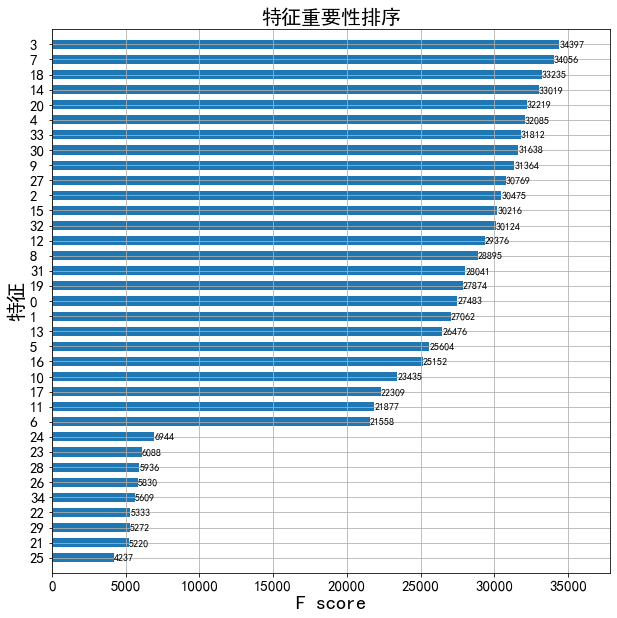

In [74]:
from xgboost import XGBClassifier
from xgboost import plot_importance
#mpl.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.sans-serif']=['SimHei'] #图中文字体设置为黑体
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 设置图例字体大小
#ax.legend(..., fontsize=20)
xgb.plot_importance(clf1, height=0.6, ax=ax)
ax.set_title('特征重要性排序',fontsize= 20) 
ax.set_xlabel('F score', fontsize=20)
ax.set_ylabel('特征', fontsize=20)
plt.savefig('feature_importance.jpg',dpi=300)
plt.show()

In [34]:
label_train = pd.DataFrame(y_train).apply(lambda x: x.argmax(), axis=1).values
label_test = pd.DataFrame(y_val).apply(lambda x: x.argmax(), axis=1).values

In [29]:
label_train

array([ 7, 10,  8, ...,  7,  0,  0], dtype=int64)

In [30]:
label_test

array([5, 7, 6, ..., 5, 9, 8], dtype=int64)